In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from kdelearn.kde import KDE
from kdelearn.kde_tasks import KDEOutliersDetection
from kdelearn.bandwidth_selection import direct_plugin

In [2]:
data = pd.read_csv("../../data/meteo/data_hourly.csv")

data["time"] = pd.to_datetime(data["time"])
data["year"] = data["time"].dt.year

In [3]:
data = data[data["year"] == 2020]
data.shape

(8572, 10)

In [4]:
data

,time,averagePm10,averageAirTemp,averageWindchill,averageHeatindex,averageRelativeHumidity,averageAirPressure,averageWindSpeed,rainIntensity,year
12783,2020-01-01 00:00:00,6.565000,3.860000,1.955000,55.953333,57.510000,973.528333,2.721667,0.0,2020
12784,2020-01-01 01:00:00,8.265000,3.913333,1.288333,55.230000,55.436667,973.525000,2.471667,0.0,2020
12785,2020-01-01 02:00:00,7.652542,3.580000,0.941667,56.806667,56.895000,973.600000,2.200000,0.0,2020
12786,2020-01-01 03:00:00,4.811864,3.621667,0.658333,56.591667,56.600000,973.808333,1.906667,0.0,2020
12787,2020-01-01 04:00:00,3.566667,3.035000,0.831667,59.143333,58.040000,974.325000,1.998333,0.0,2020
...,...,...,...,...,...,...,...,...,...,...
21350,2020-12-31 19:00:00,0.615000,5.240000,5.421667,51.768333,62.985000,991.473333,5.490000,0.0,2020
21351,2020-12-31 20:00:00,0.464407,4.886667,5.266667,53.013333,62.735000,990.905000,5.550000,0.0,2020
21352,2020-12-31 21:00:00,0.498305,4.728333,4.690000,53.526667,62.130000,990.115000,4.493333,0.0,2020
21353,2020-12-31 22:00:00,0.675000,6.050000,5.063333,48.593333,56.995000,989.816667,4.585000,0.0,2020


\newpage

# 1d

## averageAirTemp vs time

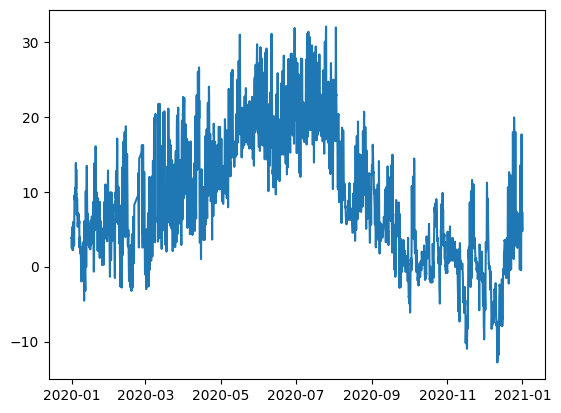

In [5]:
plt.plot(data["time"], data["averageAirTemp"])

\newpage

## averageAirPressure vs time

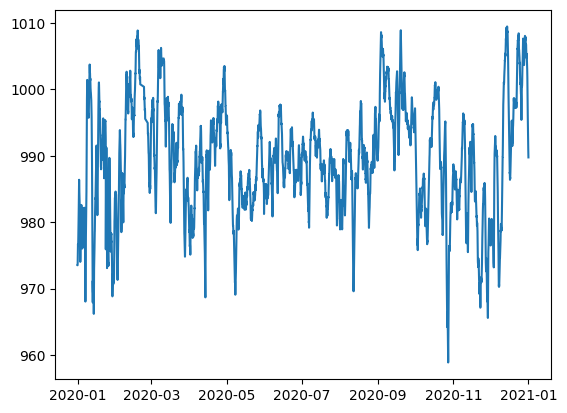

In [6]:
plt.plot(data["time"], data["averageAirPressure"])

\newpage

## averageWindSpeed vs time

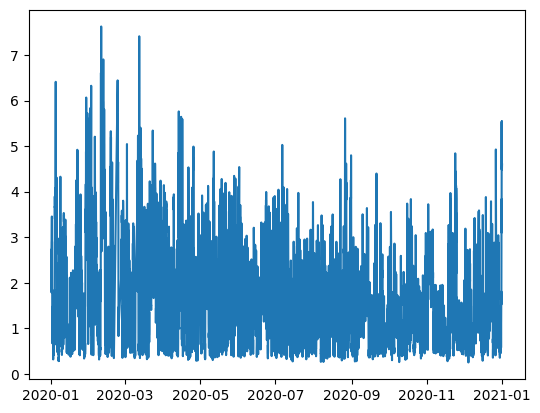

In [7]:
plt.plot(data["time"], data["averageWindSpeed"])

\newpage

## averagePm10 vs time

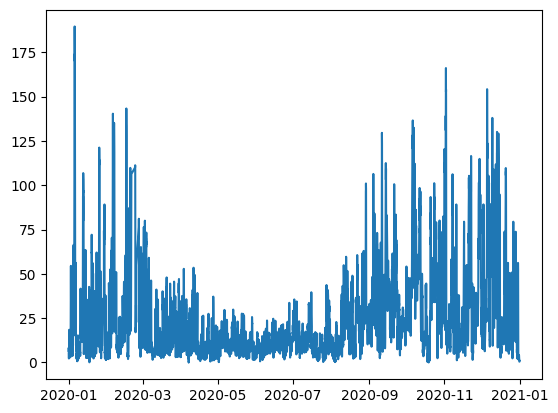

In [8]:
plt.plot(data["time"], data["averagePm10"])
plt.show()

\newpage

# 2d - outliers detection

## averageAirTemp, averageAirPressure

In [16]:
x_train = data[["averageAirTemp", "averageAirPressure"]].to_numpy(dtype=np.float64)
x_train.shape

(8572, 2)

Najlepszy mnożnik h: 1.000, r: 0.01, Wskaźnik: 0.637


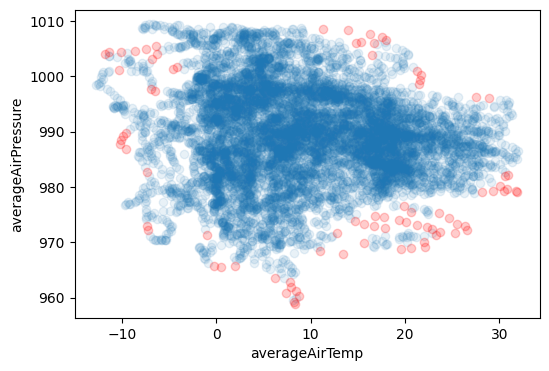

In [17]:
bandwidth = direct_plugin(x_train, stage=2)

metrics_list = []
h_mul_list = []
r_list = []
for h_mul in np.arange(0.5, 10.5, 0.5):
# for h_mul in np.arange(0.5, 2.5, 0.5):
    h_mul = round(h_mul, 3)

    for r in np.arange(0.01, 0.31, 0.01):
#     for r in np.arange(0.01, 0.31, 0.05):
        r = round(r, 3)

        kde = KDE().fit(x_train, bandwidth=bandwidth * h_mul)
        scores = kde.pdf(x_train)
        threshold = np.quantile(scores, r)
        labels_pred = np.where(scores <= threshold, 1, 0)

        n_outliers = labels_pred.sum()
        if n_outliers == 0:
            continue

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        n_inliers = (outliers == 0).sum()
        tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
        scores_out = np.sort(scores[outliers])[-tmp:]
        scores_in = np.sort(scores[inliers])[:tmp]
        metrics = np.sum(scores_out) / np.sum(scores_in)

        metrics_list.append(metrics)
        h_mul_list.append(h_mul)
        r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepszy mnożnik h: {h_mul_list[idx]:.3f}, r: {r_list[idx]}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth*h_mul_list[idx], r=r_list[idx])
labels_pred = outliers_detector.predict(x_train)

plt.figure(figsize=(6, 4))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.2, c="red")
plt.xlabel("averageAirTemp")
plt.ylabel("averageAirPressure")
plt.show()

\newpage

## averageAirTemp, averageWindSpeed

In [18]:
x_train = data[["averageAirTemp", "averageWindSpeed"]].to_numpy(dtype=np.float64)
x_train.shape

(8572, 2)

Najlepszy mnożnik h: 10.000, r: 0.01, Wskaźnik: 0.401


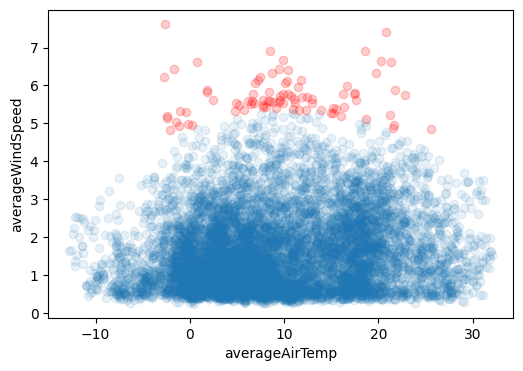

In [19]:
bandwidth = direct_plugin(x_train, stage=2)

metrics_list = []
h_mul_list = []
r_list = []
for h_mul in np.arange(0.5, 10.5, 0.5):
# for h_mul in np.arange(0.5, 2.5, 0.5):
    h_mul = round(h_mul, 3)

    for r in np.arange(0.01, 0.31, 0.01):
#     for r in np.arange(0.01, 0.31, 0.05):
        r = round(r, 3)

        kde = KDE().fit(x_train, bandwidth=bandwidth * h_mul)
        scores = kde.pdf(x_train)
        threshold = np.quantile(scores, r)
        labels_pred = np.where(scores <= threshold, 1, 0)

        n_outliers = labels_pred.sum()
        if n_outliers == 0:
            continue

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        n_inliers = (outliers == 0).sum()
        tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
        scores_out = np.sort(scores[outliers])[-tmp:]
        scores_in = np.sort(scores[inliers])[:tmp]
        metrics = np.sum(scores_out) / np.sum(scores_in)

        metrics_list.append(metrics)
        h_mul_list.append(h_mul)
        r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepszy mnożnik h: {h_mul_list[idx]:.3f}, r: {r_list[idx]}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth*h_mul_list[idx], r=r_list[idx])
labels_pred = outliers_detector.predict(x_train)

plt.figure(figsize=(6, 4))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.2, c="red")
plt.xlabel("averageAirTemp")
plt.ylabel("averageWindSpeed")
plt.show()

\newpage

## averageAirTemp, averagePm10

In [20]:
x_train = data[["averageAirTemp", "averagePm10"]].to_numpy(dtype=np.float64)
x_train.shape

(8572, 2)

Najlepszy mnożnik h: 7.500, r: 0.01, Wskaźnik: 0.384


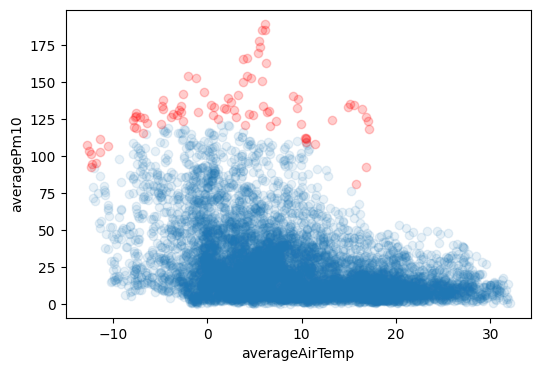

In [21]:
bandwidth = direct_plugin(x_train, stage=2)

metrics_list = []
h_mul_list = []
r_list = []
for h_mul in np.arange(0.5, 10.5, 0.5):
# for h_mul in np.arange(0.5, 2.5, 0.5):
    h_mul = round(h_mul, 3)

    for r in np.arange(0.01, 0.31, 0.01):
#     for r in np.arange(0.01, 0.31, 0.05):
        r = round(r, 3)

        kde = KDE().fit(x_train, bandwidth=bandwidth * h_mul)
        scores = kde.pdf(x_train)
        threshold = np.quantile(scores, r)
        labels_pred = np.where(scores <= threshold, 1, 0)

        n_outliers = labels_pred.sum()
        if n_outliers == 0:
            continue

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        n_inliers = (outliers == 0).sum()
        tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
        scores_out = np.sort(scores[outliers])[-tmp:]
        scores_in = np.sort(scores[inliers])[:tmp]
        metrics = np.sum(scores_out) / np.sum(scores_in)

        metrics_list.append(metrics)
        h_mul_list.append(h_mul)
        r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepszy mnożnik h: {h_mul_list[idx]:.3f}, r: {r_list[idx]}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth*h_mul_list[idx], r=r_list[idx])
labels_pred = outliers_detector.predict(x_train)

plt.figure(figsize=(6, 4))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.2, c="red")
plt.xlabel("averageAirTemp")
plt.ylabel("averagePm10")
plt.show()

\newpage

## averageWindSpeed, averagePm10

In [22]:
x_train = data[["averageWindSpeed", "averagePm10"]].to_numpy(dtype=np.float64)
x_train.shape

(8572, 2)

Najlepszy mnożnik h: 5.000, r: 0.01, Wskaźnik: 0.324


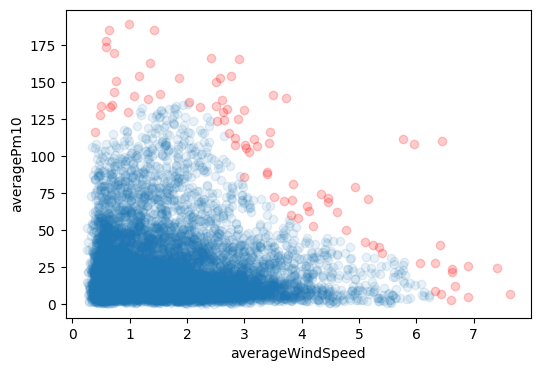

In [23]:
bandwidth = direct_plugin(x_train, stage=2)

metrics_list = []
h_mul_list = []
r_list = []
for h_mul in np.arange(0.5, 10.5, 0.5):
# for h_mul in np.arange(0.5, 2.5, 0.5):
    h_mul = round(h_mul, 3)

    for r in np.arange(0.01, 0.31, 0.01):
#     for r in np.arange(0.01, 0.31, 0.05):
        r = round(r, 3)

        kde = KDE().fit(x_train, bandwidth=bandwidth * h_mul)
        scores = kde.pdf(x_train)
        threshold = np.quantile(scores, r)
        labels_pred = np.where(scores <= threshold, 1, 0)

        n_outliers = labels_pred.sum()
        if n_outliers == 0:
            continue

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        n_inliers = (outliers == 0).sum()
        tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
        scores_out = np.sort(scores[outliers])[-tmp:]
        scores_in = np.sort(scores[inliers])[:tmp]
        metrics = np.sum(scores_out) / np.sum(scores_in)

        metrics_list.append(metrics)
        h_mul_list.append(h_mul)
        r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepszy mnożnik h: {h_mul_list[idx]:.3f}, r: {r_list[idx]}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth*h_mul_list[idx], r=r_list[idx])
labels_pred = outliers_detector.predict(x_train)

plt.figure(figsize=(6, 4))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.2, c="red")
plt.xlabel("averageWindSpeed")
plt.ylabel("averagePm10")
plt.show()